In [1]:
import torch
from torch import nn
import os


from pathlib import Path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchmetrics as TM

from typing import Optional

from torch.utils.data import Dataset

# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

# Set the working (writable) directory.
working_dir = Path("/home/fvelikon/projects/mri_cv/data/processed_data_split")

torch.cuda.is_available()

True

In [2]:
def save_model_checkpoint(model, cp_name):
    torch.save(model.state_dict(), os.path.join(working_dir, cp_name))
 
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Load model from saved checkpoint
def load_model_from_checkpoint(model, ckp_path):
    return model.load_state_dict(
        torch.load(
            ckp_path,
            map_location=get_device(),
        )
    )

# Send the Tensor or Model (input argument x) to the right device
# for this notebook. i.e. if GPU is enabled, then send to GPU/CUDA
# otherwise send to CPU.
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()
    
def get_model_parameters(m):
    total_params = sum(
        param.numel() for param in m.parameters()
    )
    return total_params

def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")
# end if

def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()
    # end while
# end def

# Validation: Check if CUDA is available
print(f"CUDA: {torch.cuda.is_available()}")

CUDA: True


In [3]:
class MRIDataset(Dataset):
    
    def __init__(self, root: Path, split_mode: str, 
                 transform: Optional[T.Compose]=None, 
                 target_transform: Optional[T.Compose]=None) -> None:
        super().__init__()
        
        self.split_dir = root / split_mode
        
        self._filenames = list(sorted([path.name for path in self.split_dir.glob("*.pt")]))
        
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self) -> int:
        
        return len(self.files)
    
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        
        filename = self._filenames[index]
        
        image_and_mask_tensor: torch.Tensor = torch.load(self.split_dir / filename)
        
        image, mask = image_and_mask_tensor
        
        return image, mask

In [4]:
train_ds = MRIDataset(root=working_dir, split_mode="train")
test_ds = MRIDataset(root=working_dir, split_mode="test")
eval_ds = MRIDataset(root=working_dir, split_mode="eval")

In [32]:
train_image_example, train_mask_example = train_ds[100]
both = torch.stack([train_image_example, train_mask_example], dim=0)
x, = torch.split(both, 2)
# x.shape, y.shape
y, z = x
y.shape, z.shape

(torch.Size([397, 772]), torch.Size([397, 772]))

(torch.Size([397, 768]), torch.Size([397, 768]))

# Bimap Legend

<div style="font-size: 20px;">
After subtracting 1 from pixel value.

* 1 = Bone structure (segmentation target)
* 0 = Background pixel
</div>

In [20]:
from enum import IntEnum
class BimapClasses(IntEnum):
    BONE = 1
    BACKGROUND = 0

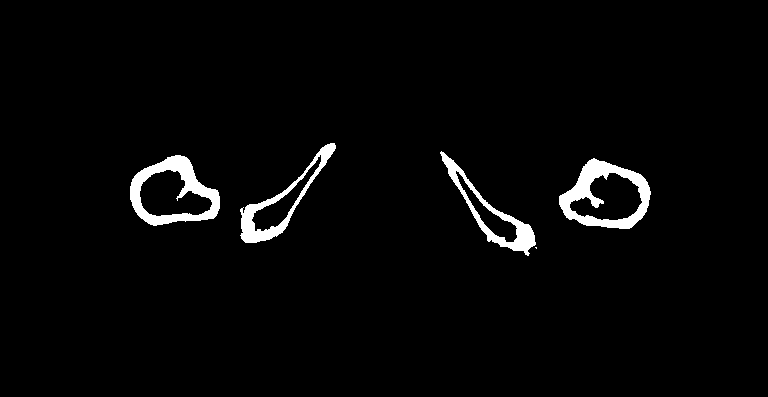

In [21]:
# Spot check a segmentation mask image after post-processing it
t2img(train_mask_example)

In [22]:
# Simple torchvision compatible transform to send an input tensor
# to a pre-specified device.
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={self.device})"


In [ ]:
# Create a dataset wrapper that allows us to perform custom image augmentations
# on both the target and label (segmentation mask) images.
#
# These custom image augmentations are needed since we want to perform
# transforms such as:
# 1. Random horizontal flip
# 2. Image resize
#
# and these operations need to be applied consistently to both the input
# image as well as the segmentation mask.
class MRIDatasetAugmented(MRIDataset):
    def __init__(
        self,
        root: Path,
        split_mode: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split_mode=split_mode,
            target_types=target_types,
            # download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)
        
        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.stack([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 2, dim=0)
        # end if
        
        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)